In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import requests
from io import StringIO
import yfinance as yf
import random
import math

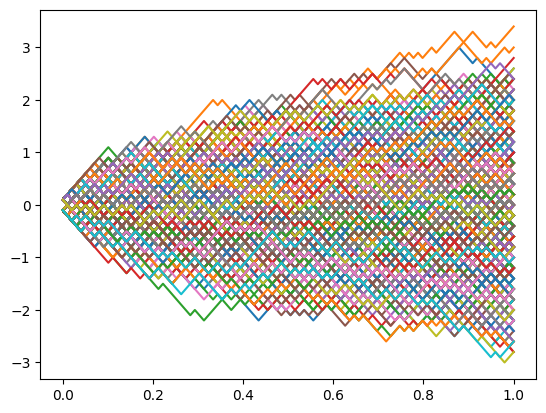

In [2]:
# Fundamentals of Stochastic Modeling 

# 1. Brownian Motion

# Brownian motion (or a Wiener process) is any process which has zero mean, linearly increasing variance as a function of time, and no autocorrelation. Thus it is any process in which the sequence of random variables all follow the same distribution. One common representation is the following

# Two-Point Wiener Processes

def twoPointDist(n):
    x = random.random()
    if x <= 0.5:
        return -1/np.sqrt(n)
    else:
        return 1/np.sqrt(n)
    
def binarySamplePath(n):
    xData172 = np.linspace(0,1,n)
    yData172 = []
    xStep = 0

    for x in xData172:
        dx = twoPointDist(100)
        xStep = xStep + dx
        yData172.append(xStep)

    return xData172, yData172

# Now build a dictionary with the keys labeling the sample path and the value storing the sample path in question. 

brownDct = {}
tIndex = np.linspace(0,1,100)

for n in range(1000):
    wienerPath = binarySamplePath(100)[1]
    brownDct[n+1] = wienerPath

wienerDf = pd.DataFrame(brownDct,tIndex)

wienerDf.plot(legend=False)
plt.show()

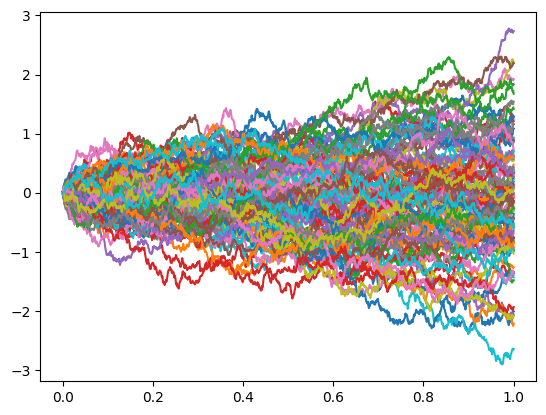

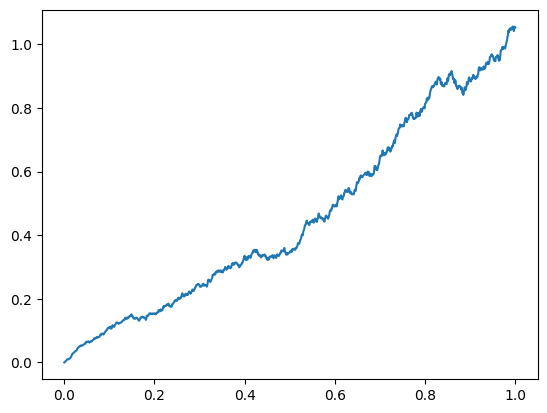

In [ ]:
# This can also be done with a Gaussian distribution, which is more common

def gaussianDist(mu,sigma):
    return np.random.normal(mu,sigma)

def gaussianWienerProc(n,t1):
    dt = t1/n

    tArray = np.linspace(dt,t1,n)
    xArray = [0]
    x = xArray[0]

    for t in tArray:
        x = x + gaussianDist(0,np.sqrt(dt))
        xArray.append(x)
        continue

    tArray = np.concat((np.array([0]),tArray))

    return tArray, xArray


gaussWienerDct = {}

for n in range(100):
    wProc = gaussianWienerProc(1000,1)
    gaussWienerDct[n+1] = wProc[1]

tIndex = wProc[0]
gaussWienerDf = pd.DataFrame(gaussWienerDct,tIndex)

gaussWienerDf.plot(legend=False)
plt.show()

std = gaussWienerDf.var(axis=1)

std.plot()
plt.show()

# Notice that the variance increases linearly with time, as expected.


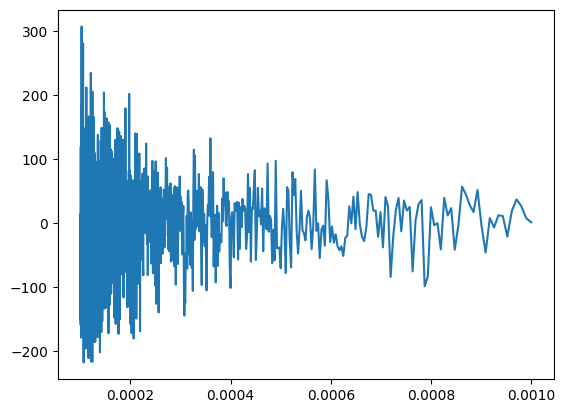

In [32]:
# What happens if we try to calculate the derivative of a Wiener process? This can be done with either the binary wiener process, or the gaussian one. We use the gaussian one for the sake of completeness. Notice the derivative diverges as the partitions become finer and finer. This suggests that the notion of derivative here doesn't necessarily make sense (although it probably does in the path space).

# Now try to evaluate the derivative of this function at t = 0.5 by numerically calculating the derivative for successively smaller areas around 0.5.

deriv174 = []
hVals174 = []

for n in range(1000,10010,10):
    yData174 = gaussianWienerProc(n,1)[1]
    index = math.floor(n/2)
    yDiff = (yData174[index+1]-yData174[index])/(1/n)
    deriv174.append(yDiff)
    hVals174.append(1/n)

plt.plot(hVals174,deriv174)

# Importantly, notice that the derivative diverges in a wild way as one tries to calculate the derivative in terms of GIVEN values, so we need to do something more general.

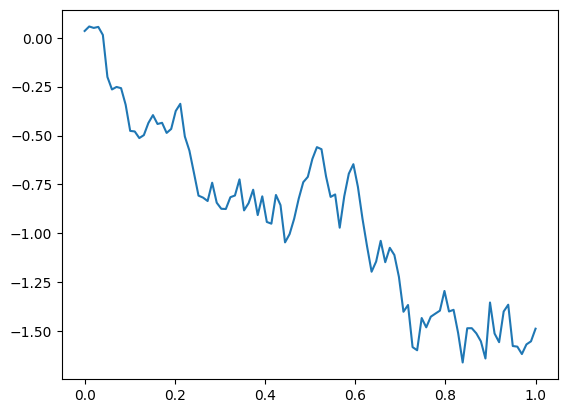

In [83]:
# We will need to be able to generally evaluate something like \int_{t_1}^{t_2} F(t)dW(t), so this little snippit does that, and defines some other important functions. 

# Integral Representation
def generalWienerIntegral(F,dt,t1,t2,n):
    tInterval = np.linspace(t1,t2,n)
    total = 0
    wienerArray = []
    for t in tInterval:
        dw = np.random.normal(0,np.sqrt(dt))
        if callable(F):
            total += F(t)*dw
        else:
            total += F*dw   # treat F as a constant
        wienerArray.append(total)
    return tInterval, wienerArray

# with checks
out = generalWienerIntegral(1, 0.01, 0, 1, 100)
plt.plot(out[0],out[1])
plt.show()

# Differential Representations
def dw(dt):
    return np.random.normal(0,np.sqrt(dt))

def xStep(f,g,dt):
    return f*dt + g*dw(dt)



In [ ]:
# 2. Stochastic Equations

# Now we solve the basic stochastic equations. We use Euler's method. 

# a. Ornstein-Uhlenbeck Process: dx = -a*x*dt + g*dW

# Direct Numerical Integration

def wienerDerivFn(x0,gamma,g,n):

    t1 = 1
    dt = t1/n

    tArray = np.linspace(0,t1,n)
    xArray = []
    xNow = x0

    for t in tArray:
        f = -gamma*xNow
        dx = xStep(f,g,dt)
        xNow += dx
        xArray.append(xNow)

    return tArray, xArray

# Numerical Representation of Analytical Solution

def exp(gamma,t):
    return np.exp(-gamma*t)

def wienerIntFn(x0,gamma,g,n):
    t1 = 1
    dt = t1/n

    tArray = np.linspace(0,t1,n)
    expFixedGamma = lambda t: exp(gamma,t)
    wienerInt = generalWienerIntegral(expFixedGamma,dt,0,t1,n)
    xArray = x0*exp(gamma,tArray) + g*exp(gamma,tArray)*wienerInt[1]
    
    return tArray, xArray

wienerIntDct = {}
wienerDerivDct = {}

for j in range(100):
    wienerIntProc = wienerIntFn(1,1,1,100)
    wienerDerivProc = wienerDerivFn(1,1,1,100)
    wienerIntDct[j+1] = wienerIntProc[1]
    wienerDerivDct[j+1] = wienerDerivProc[1]

tIntArray = wienerIntProc[0]
tDerivArray = wienerDerivProc[0]

# print(len(wienerDerivProc[0]))

wienerIntDf = pd.DataFrame(wienerIntDct,index=tIntArray)
wienerDerivDf = pd.DataFrame(wienerDerivDct,index=tDerivArray)

100


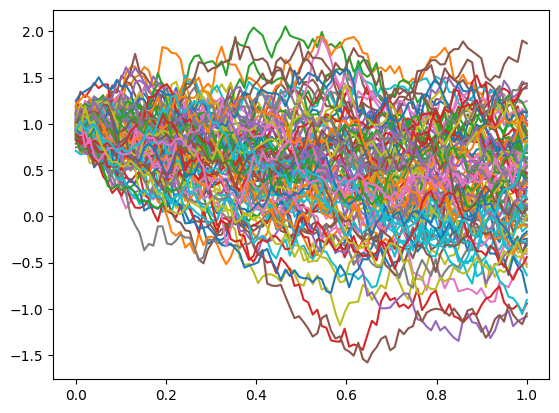

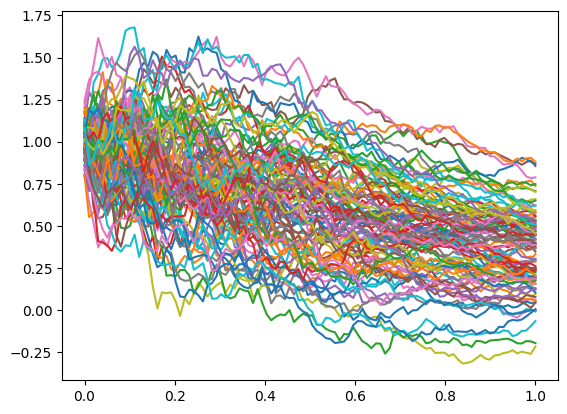

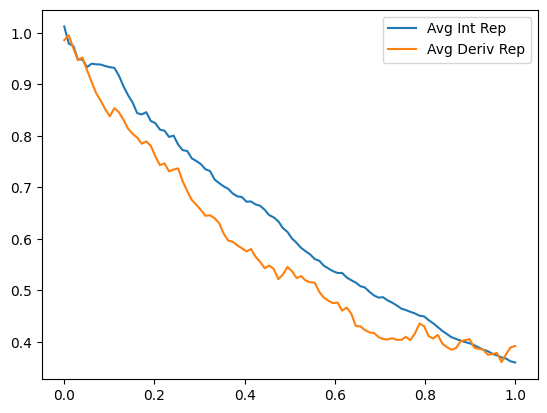

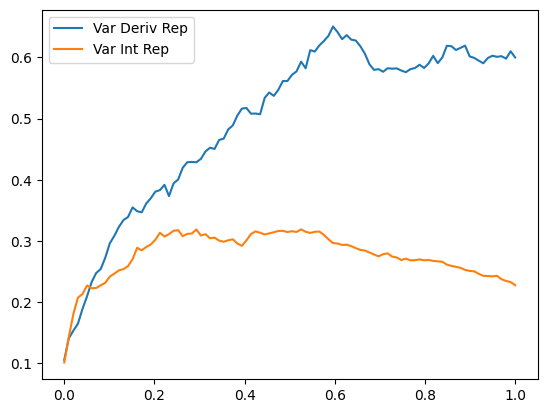

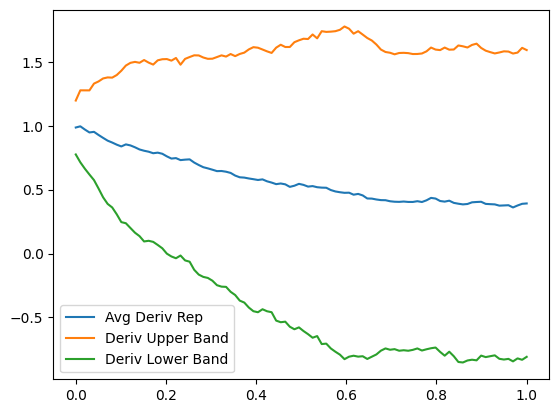

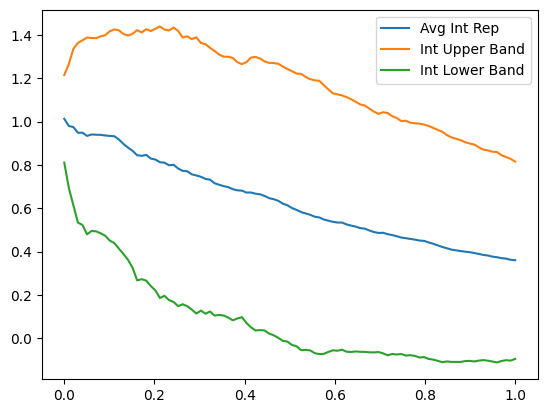

In [ ]:
# Plots of our solutions

# Numerical Integration 
for j in range(1,101):
    wienerDerivDf[j].plot()

plt.show()

# Numerical Representation of Exact Solution 
for j in range(1,101):
    wienerIntDf[j].plot()

plt.show()

wienerDerivAvg = wienerDerivDf.mean(axis=1)
wienerIntAvg = wienerIntDf.mean(axis=1)

wienerDerivVar = wienerDerivDf.std(axis=1)
wienerIntVar = wienerIntDf.std(axis=1)

wienerAvg = pd.concat([wienerIntAvg,wienerDerivAvg], axis=1)
wienerVar = pd.concat([wienerIntVar,wienerDerivVar], axis=1)

wienerAvg = wienerAvg.rename(columns={0 : "Avg Int Rep", 1 : "Avg Deriv Rep"})
wienerVar = wienerVar.rename(columns={0 : "Var Int Rep", 1 : "Var Deriv Rep"})

wienerAvg.plot()
plt.show()

wienerStats = wienerAvg.join(wienerVar)
wienerStats["Deriv Upper Band"] = wienerStats["Avg Deriv Rep"] + 2*wienerStats["Var Deriv Rep"]
wienerStats["Deriv Lower Band"] = wienerStats["Avg Deriv Rep"] - 2*wienerStats["Var Deriv Rep"]
wienerStats["Int Upper Band"] = wienerStats["Avg Int Rep"] + 2*wienerStats["Var Int Rep"]
wienerStats["Int Lower Band"] = wienerStats["Avg Int Rep"] - 2*wienerStats["Var Int Rep"]

wienerStats[["Var Deriv Rep","Var Int Rep"]].plot()
plt.show()

wienerStats[["Avg Deriv Rep","Deriv Upper Band","Deriv Lower Band"]].plot()
plt.show()

wienerStats[["Avg Int Rep","Int Upper Band","Int Lower Band"]].plot()
plt.show()



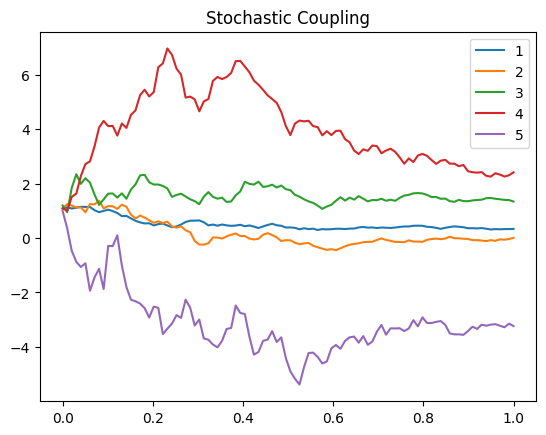

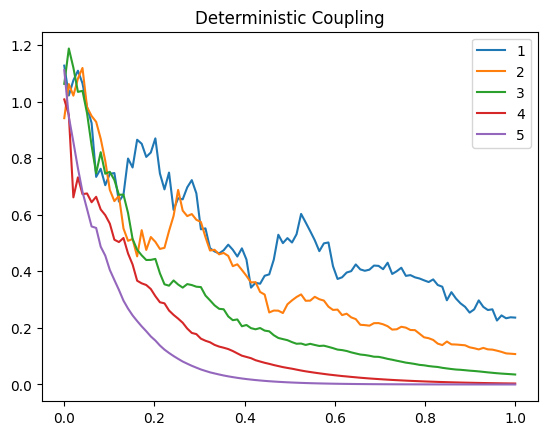

In [145]:
# Lets look at variations in f,g. We'll stick to the analytical solution

paramArray = 10**np.linspace(0,1,5)
gPaths = {}
gammaPaths = {}
k = 1

for s in paramArray:
    gPath = wienerIntFn(1,1,s,100)
    gammaPath = wienerIntFn(1,s,1,100)
    gPaths[k] = gPath[1]
    gammaPaths[k] = gammaPath[1]
    k = k+1

tArray = gPath[0]

gPathsDf = pd.DataFrame(gPaths,tArray)
gammaPathsDf = pd.DataFrame(gammaPaths,tArray)

gPathsDf.plot(legend=True,title="Stochastic Coupling")
plt.show()

gammaPathsDf.plot(legend=True,title="Deterministic Coupling")
plt.show()

# These results make sense; turning up the stochastic coupling means that the random variations become dominant in the long-time dynamics. On the other hand, turning up the coupling for the deterministic part yields a dominant overall exponential suppression factor. Obviously this mutes the statistical variation as well. 


In [185]:
# b. General linear stochastic equation: -gamma*x*dt + alpha*x*dW

# Solution by direct numerical integration

def generalStochFn(x0,gamma,alpha,t0,t1,n):

    dt = t1/n

    tArray = np.linspace(t0,t1,n)
    xArray = []
    xNow = x0

    for t in tArray:
        f = -gamma*xNow
        g = alpha*xNow
        dx = xStep(f,g,dt)
        xNow += dx
        xArray.append(xNow)

    return tArray, xArray

# This solution is correct, but suppresses the noise term. We can solve the transformed version instead and transform back.

def genTransformedStochFn(x0,gamma,alpha,t0,t1,n): 
    dt = t1/n
    tArray = np.linspace(t0,t1,n)
    xArray = []
    xNow = x0

    for t in tArray:
        f = (alpha**2/2-gamma)
        g = alpha
        dx = xStep(f,g,dt)
        xNow += dx
        xArray.append(xNow)
    
    return tArray,xArray

# Analytic Solution

def genLinearStochSoln(x0,gamma,alpha,t0,t1,n):
    tArray = np.linspace(t0,t1,n)
    dt = (t1-t0)/n
    wienerIntTuple = generalWienerIntegral(1,dt,t0,t1,n)
    return x0*np.exp((alpha**2/2-gamma)*tArray + alpha*wienerIntTuple[1])

# Generate the dataframes

genLinDerivDct = {}
genTransDerivDct = {}
genLinIntDct = {}

for j in range(10):
    genDerivSoln = generalStochFn(1,1,1,0,5,1000)
    genTransDerivSoln = genTransformedStochFn(1,1,1,0,5,1000)
    genLinDerivDct[j+1] = genDerivSoln[1]
    genTransDerivDct[j+1] = genTransDerivSoln[1]
    genLinIntDct[j+1] = genLinearStochSoln(1,1,1,0,5,1000)

tArray = genDerivSoln[0]

genLinDerivDf = pd.DataFrame(genLinDerivDct,tArray)
genTransDerivDf = pd.DataFrame(genTransDerivDct,tArray)
genUnransDerivDf = genTransDerivDf.apply(np.exp,axis=1)
genLinIntDf = pd.DataFrame(genLinIntDct,tArray)
genLinTransIntDf = genLinIntDf.apply(np.log,axis=1)


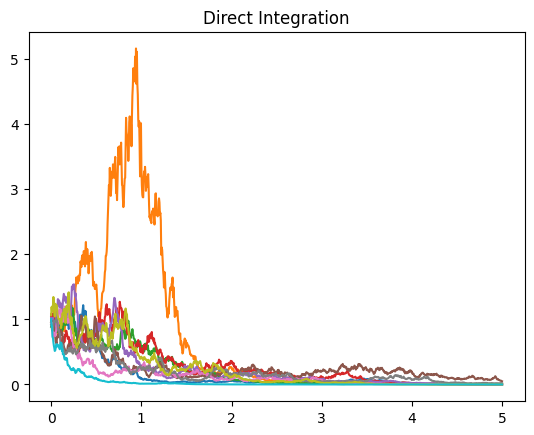

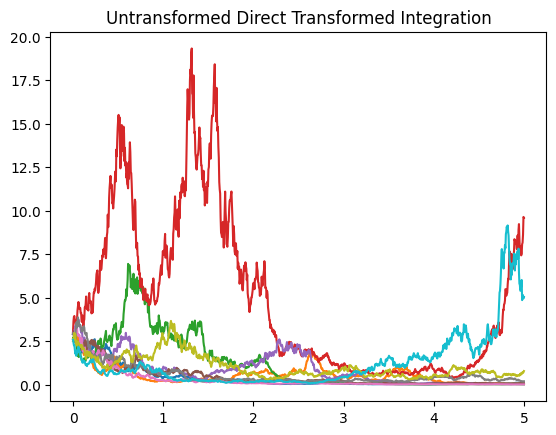

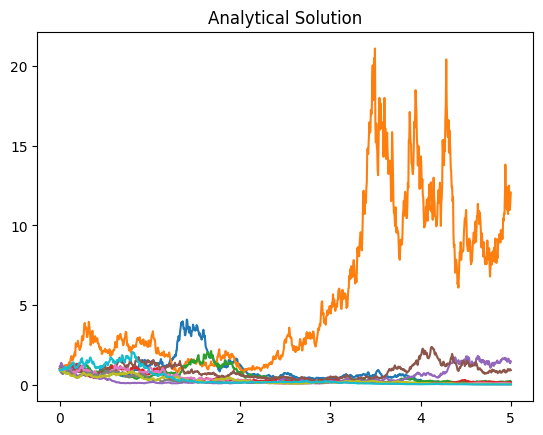

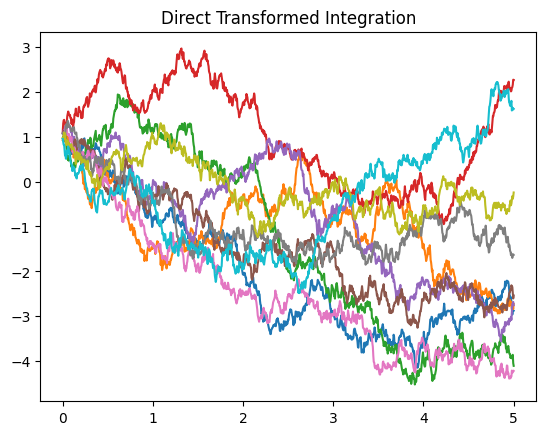

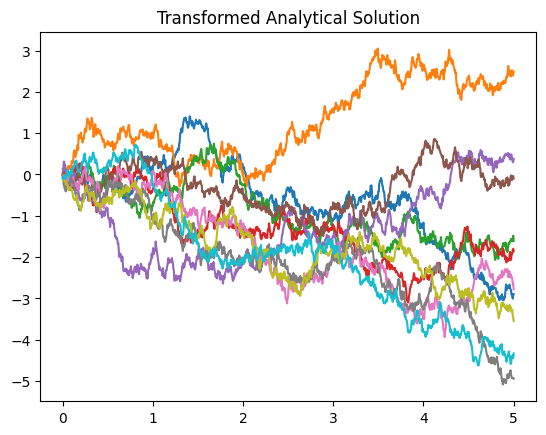

In [ ]:
# Plotting the solutions

# Direct Plots
genLinDerivDf.plot(legend=False,title="Direct Integration")
plt.show()

genUnransDerivDf.plot(legend=False,title="Untransformed Direct Transformed Integration")
plt.show()

genLinIntDf.plot(legend=False,title="Analytical Solution")
plt.show()

genTransDerivDf.plot(legend=False,title="Direct Transformed Integration")
plt.show()

genLinTransIntDf.plot(legend=False,title="Transformed Analytical Solution")
plt.show()

# Note that the analytic solution makes sense. The variance of the Wiener process grows linearly with t. Since we add a linear term in t to the Wiener process, we should expect the noise to always be prevalent. The question is why this doesn't occur in the Euler solution. The answer is that the direct integration method suppresses the noise out at long time dynamics. Why? Because at each time step, the majority of the terms fall within sqrt(dt) rather than in interval dt (because the stdev is ~sqrt(dt) in dW), whereas the deterministic term goes like dt. Over long times, the determinisitic term washes out the random term. 

# Note also that as we turn up alpha/gamma, we'll either produce an exponential increase with exponentially increasing noise (large alpha), or we will have a very muted noise term dominated by the exponential (large gamma).

